# Trying to implement spatio-temporal GP on south cascade glacier elevation data

## Installs

In [1]:
%pip install gpytorch
%pip install xarray
%pip install torch
%pip install matplotlib
%pip install urllib
%pip install xbatcher
%pip install dask
%pip install tqdm
%pip install git+https://github.com/friedrichknuth/gtsa.git 


  Using cached gpytorch-1.11-py3-none-any.whl (266 kB)
  Using cached linear_operator-0.5.2-py3-none-any.whl (175 kB)
  Using cached torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl (670.2 MB)
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)
  Using cached jaxtyping-0.2.23-py3-none-any.whl (29 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_nccl_cu12-2.18.1-py3-none-manylinux1_x86_64.whl (209.8 MB)
  Using cached triton-2.1.0-0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (89.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:

import torch
import gpytorch
from matplotlib import pyplot as plt
import urllib.request
import os
import pandas as pd
import numpy as np
import xarray as xr
import xbatcher
from dask.distributed import Client, LocalCluster
import psutil
import logging
import tools
import gtsa

%matplotlib inline

# the autoreload magic command above makes changes to dev functions put in tools.py 
# immmidiately available in the notebook without restarting the kernel.

# relevant functions put in tools.py can be transferred to a common or upstream library 
# later on during the hackweek.

In [2]:
cluster = LocalCluster(
    n_workers = psutil.cpu_count(logical=True)-1,
    silence_logs = logging.ERROR,
    threads_per_worker = 1,
)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/e-marshall/proxy/8787/status,
Dashboard: /user/e-marshall/proxy/8787/status,Workers: 3
Total threads: 3,Total memory: 30.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39771,Workers: 3
Dashboard: /user/e-marshall/proxy/8787/status,Total threads: 3
Started: Just now,Total memory: 30.90 GiB
Comm: tcp://127.0.0.1:38239,Total threads: 1
Dashboard: /user/e-marshall/proxy/33931/status,Memory: 10.30 GiB
Nanny: tcp://127.0.0.1:39889,


In [3]:
baker_url = 's3://petrichor/geosmart/baker.zarr/'
scg_url = 's3://petrichor/geosmart/scg.zarr/'

In [4]:
#baker_ds = xr.open_dataset(baker_url, chunks='auto', engine='zarr', storage_options={"anon": True})
scg_ds = xr.open_dataset(scg_url, chunks='auto', engine='zarr', storage_options={"anon": True})

### Dataset overview

In [5]:
#subset south cascade glacier ds
scg_sub = gtsa.geospatial.extract_dataset_center_window(scg_ds, size=100)

Dataset center: 643993.428, 5358023.985
Test column size: 200.0 by 200.0 in spatial coordinate units.
No CRS defined.
Using xarray slicing to select data along spatial coordinate axes.


/srv/conda/envs/notebook/lib/python3.10/site-packages/gtsa/geospatial.py:78: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  xmode = np.abs(scipy.stats.mode(ds["y"].diff("y"))[0])
/srv/conda/envs/notebook/lib/python3.10/site-packages/gtsa/geospatial.py:79: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to Tr

In [6]:
scg_sub

<xarray.Dataset>
Dimensions:      (time: 71, y: 101, x: 101)
Coordinates:
  * time         (time) datetime64[ns] 1958-08-13 1967-09-21 ... 2021-08-13
  * x            (x) float64 6.439e+05 6.439e+05 ... 6.441e+05 6.441e+05
  * y            (y) float64 5.358e+06 5.358e+06 ... 5.358e+06 5.358e+06
Data variables:
    band1        (time, y, x) float32 dask.array<chunksize=(71, 51, 51), meta=np.ndarray>
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:      Area
    TIFFTAG_ARTIST:     U.S. Geological Survey Benchmark Glacier Program
    TIFFTAG_COPYRIGHT:  Public Domain
    add_offset:         0.0
    crs:                PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM[...
    scale_factor:       1.0

In [7]:
scg_sub.nbytes/1e6

2.899276

### Plot bounds on interactive map

In [8]:
#baker_gdf = tools.bounds2polygon(*baker_ds.rio.bounds(),baker_ds.rio.crs)
#baker_gdf.explore(tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
#               attr='Google')

scg_gdf = tools.bounds2polygon(*scg_sub.rio.bounds(),scg_sub.rio.crs)
scg_gdf.explore(tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
                attr='Google')

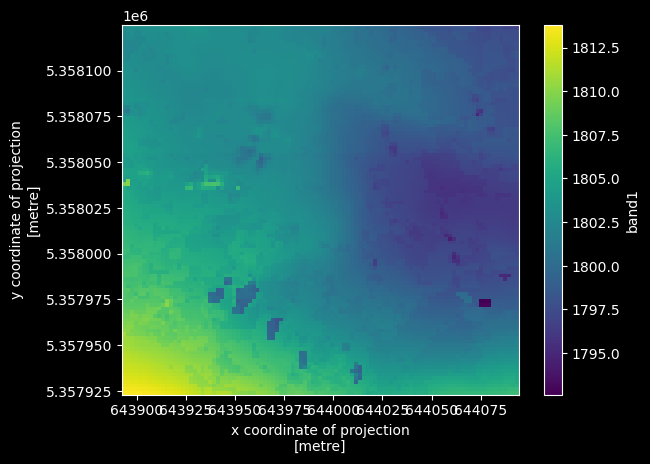

In [11]:
scg_sub.mean(dim='time').band1.plot();

In [29]:
#tools.plot_percent_area_coverage(baker_ds, 'mount baker \n percent DEM area coverage')

In [14]:
#tools.plot_percent_area_coverage(scg_ds, title = 'south cascade glacier -- percent DEM area coverage')

## Prepare subset of data for GP 

In [9]:
def swap_time_dim(ds):
    ds['time_numeric'] = ds.time.dt.year + ds.time.dt.dayofyear / 365
    ds = ds.swap_dims({'time':'time_numeric'})
    return ds

def prep_data_to_tensor(ds): #got some of this from gh issue
    
    #ds = swap_time_dim(ds)

    
    x = ds.coords['x'].data
    y = ds.coords['y'].data
    t = ds.coords['time_numeric'].data
    z = ds.band1.data.ravel()
    
    
    xv, yv,tv = torch.meshgrid(torch.from_numpy(x),
                        torch.from_numpy(y),
                        torch.from_numpy(t), indexing = 'ij')
    zv = torch.from_numpy(z)
    
    train_x = torch.cat(( #concatenates given seq of tensors in a given dim
    xv.contiguous().view(xv.numel(), 1), #returns contiguous in mem array, view rehsapes and numel returns # elements -- so this is like np reshape to 1xlen
    yv.contiguous().view(yv.numel(), 1),
    tv.contiguous().view(tv.numel(), 1)),
    dim=1 #dim to pass to cat
    )
    train_y = zv
    
    return (train_x, train_y)

In [10]:
scg_sub = swap_time_dim(scg_sub)

In [11]:
#format dataset into chunks -- this fn only returns a single chunk
# to grab a different chunk, remove iter call and index bgen like list
def format_chunks(ds):
    
    bgen = iter(xbatcher.BatchGenerator(ds, {'x':50,
                                             'y':50, 
                                             'time_numeric':int(np.ceil(len(ds.time_numeric)/2))},
                                            input_overlap={'time_numeric':9}
                                       ))
    chunk = next(bgen)
    return chunk
                

In [12]:
scg_chunk = format_chunks(scg_sub)

In [13]:
scg_chunk

<xarray.Dataset>
Dimensions:       (time_numeric: 36, y: 50, x: 50)
Coordinates:
    time          (time_numeric) datetime64[ns] 1958-08-13 ... 2016-01-06
  * x             (x) float64 6.439e+05 6.439e+05 ... 6.44e+05 6.44e+05
  * y             (y) float64 5.358e+06 5.358e+06 ... 5.358e+06 5.358e+06
  * time_numeric  (time_numeric) float64 1.959e+03 1.968e+03 ... 2.016e+03
Data variables:
    band1         (time_numeric, y, x) float32 1.856e+03 1.856e+03 ... 1.793e+03
    spatial_ref   int64 0
Attributes:
    AREA_OR_POINT:      Area
    TIFFTAG_ARTIST:     U.S. Geological Survey Benchmark Glacier Program
    TIFFTAG_COPYRIGHT:  Public Domain
    add_offset:         0.0
    crs:                PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM[...
    scale_factor:       1.0

Taking the third chunk because it was the first one with more than one time step of coverage

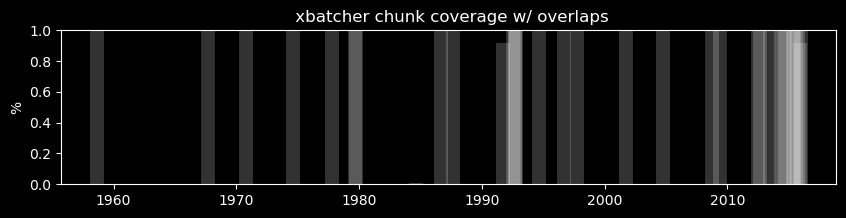

In [17]:
tools.plot_percent_area_coverage(scg_chunk, title = ' xbatcher chunk coverage w/ overlaps')


In [19]:
#format and generate test data (following george's code)
#train_x_chunk, train_y_chunk = prep_data_to_tensor(bgen[2])

In [72]:
#format data from a single chunk into a df 
#data_chunk1 = scg_chunk.to_dataframe().dropna().reset_index().rename({'band1':'z'},axis=1).drop(['spatial_ref','time'],axis=1)

In [14]:
scg_chunk = scg_chunk.isel(time_numeric=slice(2,20))

In [15]:
tensor_x, tensor_y  = prep_data_to_tensor(scg_chunk)

In [16]:
train_tensor_x = tensor_x[int(len(tensor_x)*0.8):]
train_tensor_y = tensor_y[int(len(tensor_y)*0.8):]

test_tensor_x = tensor_x[:int(len(tensor_x)*0.2)]
test_tensor_y = tensor_y[:int(len(tensor_y)*0.2)]

print(train_tensor_x.shape)
print(train_tensor_y.shape)
print(test_tensor_y.shape)

torch.Size([9000, 3])
torch.Size([9000])
torch.Size([9000])


In [17]:
train_tensor_x.shape #x,y,time

torch.Size([9000, 3])

In [18]:
test_tensor_x.shape 

torch.Size([9000, 3])

In [19]:
train_tensor_y.shape # z

torch.Size([9000])

In [20]:
grid_bounds = [(0,1),(0,2),(0,3)]
grid_size = int(len(train_tensor_y))
grid = torch.zeros(grid_size, len(grid_bounds))

In [18]:
for i in range(len(grid_bounds)):
    grid_diff = float(grid_bounds[i][1] - grid_bounds[i][0]) / (grid_size - 2)
    grid[:, i] = torch.linspace(grid_bounds[i][0] - grid_diff, grid_bounds[i][1] + grid_diff, grid_size)

In [19]:
grid.shape

torch.Size([9000, 3])

In [21]:
#use grid kernel here? 

class SpatioTempGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        
        super(SpatioTempGP, self).__init__(train_x, train_y, likelihood)#, grid_size, grid_dim)
        self.grid_size = 10
        self.grid_dim = 3
        self.mean_module = gpytorch.means.ConstantMean()
        self.spatial_kernel = gpytorch.kernels.RBFKernel()
        self.temporal_kernel = gpytorch.kernels.PeriodicKernel()
        #self.grid_kernel = gpytorch.kernels.GridKernel(self.spatial_kernel, grid=grid)
        #self.covar_module = self.grid_kernel + self.temporal_kernel
        self.covar_module = self.spatial_kernel + self.temporal_kernel
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [22]:
model.covar_module.kernels[0].lengthscale.item()

NameError: name 'model' is not defined

In [23]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpatioTempGP(train_tensor_x, train_tensor_y, likelihood)

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 

In [25]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [26]:
model(train_tensor_x)

MultivariateNormal(loc: torch.Size([9000]))

In [27]:
train_tensor_x.shape
train_tensor_y.shape

torch.Size([9000])

In [28]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 12

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_tensor_x)
    #print(type(output))
    # Calc loss and backprop gradients
    loss = -mll(output, train_tensor_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f lengthscale: %.3f  noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.kernels[0].lengthscale.item(),
        model.covar_module.kernels[1].lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/12 - Loss: 3411.599   lengthscale: 0.693 lengthscale: 0.693  noise: 0.693
Iter 2/12 - Loss: 2986.410   lengthscale: 0.744 lengthscale: 0.744  noise: 0.744
Iter 3/12 - Loss: 2652.840   lengthscale: 0.794 lengthscale: 0.798  noise: 0.798
Iter 4/12 - Loss: 2370.769   lengthscale: 0.847 lengthscale: 0.853  noise: 0.853
Iter 5/12 - Loss: 2056.582   lengthscale: 0.904 lengthscale: 0.909  noise: 0.909
Iter 6/12 - Loss: 1804.726   lengthscale: 0.963 lengthscale: 0.967  noise: 0.965
Iter 7/12 - Loss: 1740.544   lengthscale: 1.026 lengthscale: 1.024  noise: 1.023
Iter 8/12 - Loss: 1418.098   lengthscale: 1.091 lengthscale: 1.082  noise: 1.079
Iter 9/12 - Loss: 1465.880   lengthscale: 1.154 lengthscale: 1.139  noise: 1.138
Iter 10/12 - Loss: 1359.199   lengthscale: 1.219 lengthscale: 1.196  noise: 1.196
Iter 11/12 - Loss: 1264.094   lengthscale: 1.284 lengthscale: 1.252  noise: 1.251
Iter 12/12 - Loss: 1188.697   lengthscale: 1.349 lengthscale: 1.308  noise: 1.303


In [35]:
print(type(test_tensor_x))
print(type(train_tensor_x))


<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [38]:
model.covar_module.get_parameter
mean_cache = train_train_covar.evaluate_kernel().solve(train_labels_offset).squeeze(-1)

<bound method Module.get_parameter of AdditiveKernel(
  (kernels): ModuleList(
    (0): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (1): PeriodicKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_period_length_constraint): Positive()
    )
  )
)>

In [32]:
model.eval()
likelihood.eval()


with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_tensor_x))

RuntimeError: expected m1 and m2 to have the same dtype, but got: double != float

In [85]:
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [ ]:
with gpytorch.settings.fast_pred_var():
    predictions = model(test_tensor_x)

## Try spatial GP on spatial subset and temporal mean of SCG chunk -- 2d

In [19]:
#format data into train and test datasets  -- taking 80:20 for train:test
#first as np arrays
scg_x_np = scg_chunk.x.data
scg_y_np = scg_chunk.y.data
scg_z_np = scg_chunk.band1.mean(dim='time_numeric').data

In [20]:
scg_z_np

array([[1820.1283, 1820.6112, 1820.6589, ..., 1816.8641, 1816.6454,
        1816.6841],
       [1820.2026, 1821.1635, 1820.7654, ..., 1816.8278, 1816.8123,
        1817.0181],
       [1820.1885, 1820.6732, 1821.2119, ..., 1816.8767, 1816.8859,
        1816.9856],
       ...,
       [1823.2078, 1823.0796, 1822.9535, ..., 1819.5013, 1819.3636,
        1819.2751],
       [1823.3024, 1823.2157, 1823.1067, ..., 1819.5399, 1819.4105,
        1819.3262],
       [1823.3914, 1823.341 , 1823.2238, ..., 1819.5913, 1819.4498,
        1819.354 ]], dtype=float32)

In [23]:
scg_z_np_train = scg_z_np[:int(len(scg_z_np)*0.8)]
scg_z_np_test = scg_z_np[-int(len(scg_z_np)*0.2):]

In [27]:
#then format as tensors
scg_grid = torch.from_numpy(np.stack([scg_x_np, scg_y_np], axis=-1))
scg_xy = gpytorch.utils.grid.create_data_from_grid(scg_grid)
scg_z = torch.from_numpy(scg_z_np.ravel())

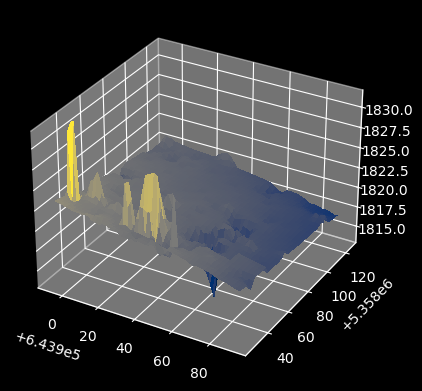

In [28]:
size=50
#grid, xy,z = make_test_dataset(size, (-3,3), 0,0,1,1,0.05)
                            
                            
shape = (size, size)
fig, ax = plt.subplots(subplot_kw = {'projection':'3d'})

surf = ax.plot_surface(
    scg_xy[:, 0].numpy().reshape(shape),
    scg_xy[:, 1].numpy().reshape(shape),
    scg_z_np, cmap='cividis',
    linewidth=0, antialiased=False)
plt.show()

split into test, train: 

In [29]:
train_scg_xy = torch.from_numpy(scg_xy.numpy()[:int(len(scg_xy)*0.8)])
train_scg_z = torch.from_numpy(scg_z.numpy()[:int(len(scg_z)*0.8)])

In [30]:
test_scg_xy = torch.from_numpy(scg_xy.numpy()[-int(len(scg_xy)*0.2):])
test_scg_z = torch.from_numpy(scg_z.numpy()[-int(len(scg_z)*0.2):])


In [31]:
test_scg_z.shape

torch.Size([500])

In [32]:
## Define the Model
# got from here: https://github.com/rmsander/learning-machine_learning/blob/master/python/machine_learning_in_python/gaussian_process_regression/gpytorch/batched_multidimensional_gpytorch.ipynb
## Define the Model
class GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()#batch_shape=torch.Size([shape]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(),#batch_shape=torch.Size([shape])),
            
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [45]:
import gc
EPOCHS = 50

def train_gp_scalar(train_xy, train_z, epochs=10, lr=0.1):
    """Computes a Gaussian Process object using GPyTorch. Each outcome is
    modeled as a single scalar outcome.
    """

    # initialize likelihood and model - batch over output dimensions and batches
    likelihood = gpytorch.likelihoods.GaussianLikelihood()#batch_shape=torch.Size([B * YD]))
    model = GP(train_xy, train_z, likelihood)# , B * YD)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Define training helper function
    def epoch_train():
        optimizer.zero_grad()  # Zero gradients
        output = model(train_xy) # Compute noise-free output
        #print(type(output.mean))
        loss = -mll(output, train_z).sum()  # Compute batched loss
        loss.backward()  # Compute gradients with backpropagation
        optimizer.step()  # Update weights with gradients
        optimizer.zero_grad()  # Zero gradients
        gc.collect()  # Used to ensure there is no memory leak
        return loss, model.covar_module.base_kernel.lengthscale.item(), model.likelihood.noise.item()
    # Run training
    for i in range(EPOCHS):
        loss, model_kern_lengthscale, likelihood_noise = epoch_train()
        print('Epoch %d/%d - loss: %.3f lengthscale: %.3f noise: %.3f' % (
            i + 1, EPOCHS, loss, model_kern_lengthscale, likelihood_noise))

    #torch.cuda.empty_cache()
    #return model, likelihood

In [41]:
print(type(train_scg_z))

<class 'torch.Tensor'>


In [53]:
EPOCHS = 50
# Time GPyTorch training
model, likelihood = train_gp_scalar(train_scg_xy.double(), train_scg_z,
                         epochs=EPOCHS, lr=0.1)

# Calling .eval() places the model and likelihood in "posterior" mode
model.eval()
likelihood.eval()

# Define mll
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

Epoch 1/50 - loss: 1111763.200 lengthscale: 0.744 noise: 0.744
Epoch 2/50 - loss: 1005560.039 lengthscale: 0.798 noise: 0.798
Epoch 3/50 - loss: 905180.054 lengthscale: 0.855 noise: 0.853
Epoch 4/50 - loss: 811054.270 lengthscale: 0.914 noise: 0.909
Epoch 5/50 - loss: 723650.522 lengthscale: 0.975 noise: 0.967
Epoch 6/50 - loss: 643364.915 lengthscale: 1.039 noise: 1.024
Epoch 7/50 - loss: 570440.890 lengthscale: 1.106 noise: 1.081
Epoch 8/50 - loss: 504923.127 lengthscale: 1.174 noise: 1.137
Epoch 9/50 - loss: 446650.220 lengthscale: 1.244 noise: 1.192
Epoch 10/50 - loss: 395278.118 lengthscale: 1.316 noise: 1.245
Epoch 11/50 - loss: 350322.771 lengthscale: 1.388 noise: 1.297
Epoch 12/50 - loss: 311210.334 lengthscale: 1.461 noise: 1.346
Epoch 13/50 - loss: 277325.033 lengthscale: 1.533 noise: 1.393
Epoch 14/50 - loss: 248048.796 lengthscale: 1.606 noise: 1.437
Epoch 15/50 - loss: 222790.514 lengthscale: 1.677 noise: 1.479
Epoch 16/50 - loss: 201004.205 lengthscale: 1.748 noise: 1.519

TypeError: cannot unpack non-iterable NoneType object

Not sure where the below issue is coming from... 

In [55]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Obtain the predictive mean and covariance matrix
    f_preds = model(test_scg_xy)
    f_mean = f_preds.mean
    f_cov = f_preds.covariance_matrix

RuntimeError: expected m1 and m2 to have the same dtype, but got: double != float

In [54]:
with gpytorch.settings.fast_pred_var():
    #predictions = model(test_scg_xy.double())
    predictions = model(test_scg_xy)

RuntimeError: expected m1 and m2 to have the same dtype, but got: double != float

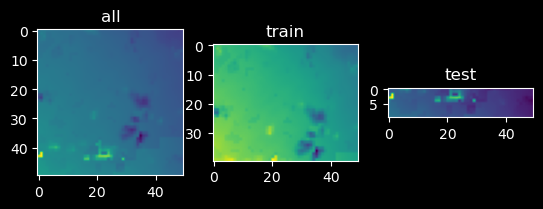

In [36]:
fig, axs = plt.subplots(ncols = 3)

axs[0].imshow(scg_z_np)
axs[0].set_title('all')

axs[1].imshow(scg_z_np_train)
axs[1].set_title('train')

axs[2].imshow(scg_z_np_test)
axs[2].set_title('test');

In [37]:
mll

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): GP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
)

## scratch stuff -- recreating example in gh issue

In [ ]:
# data setup example

L = [i for i in range(20)]
A = [i for i in range(5)]
T = [i for i in range(30)]

In [24]:
L

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [7]:
def cartesian(*arrays):
    mesh = np.meshgrid(*arrays) 
    dim = len(mesh)
    elements = mesh[0].size
    flat = np.concatenate(mesh).ravel() #flatten mesh grid
    reshape = np.reshape(flat, (dim, elements)).T 
    return reshape

In [8]:
def cartesian(*arrays):
    mesh = np.meshgrid(*arrays) 
    dim = len(mesh)
    elements = mesh[0].size
    flat = np.concatenate(mesh).ravel() #flatten mesh grid
    reshape = np.reshape(flat, (dim, elements)).T 
    return reshape
def prep_data(name_list, *arrays):
    cartprod = cartesian(*arrays)
    dout = pd.DataFrame(cartprod)
    dout.columns = name_list
    return dout

In [11]:
dtt = prep_data(['L','A','T'], L,A,T)

In [25]:
dtt

,L,A,T,x1,x2,y
0,0,0,0,0.912498,0.815313,0.900489
1,0,0,1,0.019954,0.787148,0.416830
2,0,0,2,0.848768,0.158743,0.864775
3,0,0,3,0.714632,0.907067,0.562938
4,0,0,4,0.427587,0.267526,0.484298
...,...,...,...,...,...,...
2995,19,4,25,0.352169,0.420273,0.479850
2996,19,4,26,0.438640,0.282048,0.283001
2997,19,4,27,0.712919,0.437210,0.363307
2998,19,4,28,0.839065,0.659513,0.772225


In [12]:
#simulate random values
beta_x1 = 0.4
beta_x2 = 0.3
LL_noise = 0.25

In [13]:
dtt['x1'] = np.random.uniform(size=dtt.shape[0])
dtt['x2'] = np.random.uniform(size=dtt.shape[0])
dtt['y'] = beta_x1*dtt['x1'] + beta_x2*dtt['x2'] + np.random.normal(scale=LL_noise, size = dtt.shape[0])

In [17]:
train_x = torch.from_numpy(dtt[['x1','x2','L','A','T']].values.astype(np.double)).to(torch.float)
train_y = torch.from_numpy(dtt[['y']].values[:,0].astype(np.double)).to(torch.float)
test_x = torch.from_numpy(dtt[['x1','x2','L','A','T']].values.astype(np.double)).to(torch.float)

In [19]:
train_x.shape

torch.Size([3000, 5])

In [21]:
train_y.shape

torch.Size([3000])

In [23]:
test_x.shape

torch.Size([3000, 5])

In [224]:
class Kernel(gpytorch.kernels.Kernel):
    def __init__(self):
        super(Kernel, self).__init__()
        self.matern_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=3/2), num_dims=3, active_dims=[0,1,2])
        self.periodic_kernel = gpytorch.kernels.PeriodicKernel(num_dims=3, active_dims=[0])
        #self.noise_kernel = gpytorch.kernels.WhiteNoiseKernel()
    def forward(self, x1, x2, **params):
        #    cov = kernel.forward(X, X).evaluate().detach().numpy()[0, :, :] <--- need to specify dims for each kernel doign something like this
        # from https://github.com/cornellius-gp/gpytorch/issues/526               but where forward called on kernel ? 
        matern_term = self.matern_kernel(x1, x2, **params)
        periodic_term = self.periodic_kernel(x1, x2, **params)
        return matern_term + periodic_term + WhiteNoiseKernel()

In [225]:
test_kernel = Kernel()

In [226]:
test_kernel

Kernel(
  (matern_kernel): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
  (periodic_kernel): PeriodicKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_period_length_constraint): Positive()
  )
)

In [57]:
class Kernel(gpytorch.kernels.Kernel):
    def __init__(self):
        super(Kernel, self).__init__()
        self.matern_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=3/2), num_dims=3, active_dims=[0,1,2])
        self.periodic_kernel = gpytorch.kernels.PeriodicKernel(num_dims=3, active_dims=[0])
        #self.noise_kernel = gpytorch.kernels.WhiteNoiseKernel()
    def forward(self, x1, x2, **params):
        #    cov = kernel.forward(X, X).evaluate().detach().numpy()[0, :, :] <--- need to specify dims for each kernel doign something like this
        # from https://github.com/cornellius-gp/gpytorch/issues/526               but where forward called on kernel ? 
        matern_term = self.matern_kernel(x1, x2, **params)
        periodic_term = self.periodic_kernel(x1, x2, **params)
        return matern_term + periodic_term + WhiteNoiseKernel()

test_kernel = Kernel()

class GP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, time_train, likelihood):
        super(GP, self).__init__(x_train, y_train, likelihood)
        self.mean = gpytorch.means.ConstantMean()
        self.cov_time = test_kernel#.forward(x,x).evaluate().detach().numpy()[0,:,:]
        #then do something like the above for each dim ? 
        #self.cov.initialize_from_data(x_train, y_train)
        
    def forward(self, x1, x2):
        # Evaluate the mean and kernel function at x
        mean_x = self.mean(x)
        cov_x = self.cov(x)
        # Return the multivariate normal distribution using the evaluated mean and kernel function
        return gpytorch.distributions.MultivariateNormal(mean_x, cov_x) 


In [58]:
#x_tensor, y_tensor_time_tensor

In [59]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = GP(x_tensor, y_tensor, time_tensor, likelihood)

NameError: name 'x_tensor' is not defined

In [229]:
model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [203]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


In [211]:
mll

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): GP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean): ConstantMean()
    (cov): Kernel(
      (matern_kernel): ScaleKernel(
        (base_kernel): MaternKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
      (periodic_kernel): PeriodicKernel(
        (raw_lengthscale_constraint): Positive()
        (raw_period_length_constraint): Positive()
      )
    )
  )
)